In [1]:
import sys
sys.path.append("../scripts/")
from gridmap import *
import math
import copy
from matplotlib.animation import PillowWriter    #アニメーション保存用
neigbor_grids = np.array([[1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1]])
theta_neigbors = np.array([0, np.pi / 4, np.pi / 2, 3 * np.pi / 4, np.pi, -3 * np.pi / 4, -np.pi / 2, -np.pi / 4])

In [2]:
class BUG():
    def __init__(self, grid_map_world):
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        self.id_map = np.full(self.grid_map.shape, 0)    #グリッドIDマップ
        self.grid_pair = []
        self.m_line = []
        self.alongObstacle = False
        self.nextObstacle = []
        
        index = 0
        for index_x, grids in enumerate(self.grid_map):
            for index_y, grid in enumerate(grids):
                self.id_map[index_x][index_y] = index;
                if(grid == '2'):
                    self.nowIndex = [index_x, index_y]
                index += 1
        self.getMLine()
                
    def getMLine(self):
        index = self.world.start_index
        while(index != self.world.goal_index):
            next_index = copy.copy(index)
            theta_g = np.arctan2(index[1] - self.world.goal_index[1], index[0] - self.world.goal_index[0])
            theta_sort = np.abs((theta_g - theta_neigbors + 2 * np.pi) % (2 * np.pi) - np.pi)
            neigbor_grid = np.argsort(theta_sort)[0]
            next_index = list(index + neigbor_grids[neigbor_grid])
            self.m_line.append(next_index)
            index = next_index
      
    def draw(self, ax, elems):
        if(self.world.goal_index == self.nowIndex):
            pass
        else:
            self.nowIndex = self.next(self.nowIndex, ax, elems)
            if(self.world.goal_index != self.nowIndex):
                self.drawGrid(ax, elems, self.nowIndex, "red")
    
    def next(self, index, ax, elems):
        next_index = None
        if(index in self.m_line):
            self.alongObstacle = False
            next_chk_index = copy.copy(index)
            theta_g = np.arctan2(index[1] - self.world.goal_index[1], index[0] - self.world.goal_index[0])
            theta_sort = np.abs((theta_g - theta_neigbors + 2 * np.pi) % (2 * np.pi) - np.pi)
            flag_obs = False
            neigbor_grid = np.argsort(theta_sort)[0]
            next_chk_index = list(index + neigbor_grids[neigbor_grid])
            if(self.isObstacle(next_chk_index)):
                self.alongObstacle = True
        if(self.alongObstacle is False):
            next_index = copy.copy(index)
            theta_g = np.arctan2(index[1] - self.world.goal_index[1], index[0] - self.world.goal_index[0])
            theta_sort = np.abs((theta_g - theta_neigbors + 2 * np.pi) % (2 * np.pi) - np.pi)
            flag_obs = False
            neigbor_grid = np.argsort(theta_sort)[0]
            next_index = list(index + neigbor_grids[neigbor_grid])
            if(self.isObstacle(next_index)):
                self.alongObstacle = True
        if(self.alongObstacle is True):
            next_robot_candidate = []
            if(next_index is not None):
                neigbor_obs_cans = []
                for prev_obs in self.prev_obses:
                    for grid in neigbor_grids:
                        neigbor_obs = [prev_obs[0] + grid[0], prev_obs[1] + grid[1]]
                        if not(neigbor_obs in neigbor_obs_cans):
                            neigbor_obs_cans.append(neigbor_obs)
                for neigbor_obs_can in neigbor_obs_cans:
                    if(self.isObstacle(neigbor_obs_can)):
                        self.nextObstacle.append(neigbor_obs_can)
                        for grid2 in neigbor_grids:
                            neigbor_robot_can = [index[0] + grid2[0], index[1] + grid2[1]]
                            if(self.isNeigbor(neigbor_obs_can, neigbor_robot_can) and not(self.isObstacle(neigbor_robot_can))):
                                next_robot_candidate.append([neigbor_robot_can, neigbor_obs_can])
                next_index = next_robot_candidate[0][0]
            else:
                neigbor_obs_cans = []
                for prev_obs in self.prev_obses:
                    neigbor_obs_cans.append(prev_obs)
                    for grid in neigbor_grids:
                        neigbor_obs = [prev_obs[0] + grid[0], prev_obs[1] + grid[1]]
                        if(not(neigbor_obs in neigbor_obs_cans)  and self.isObstacle(neigbor_obs)):
                            neigbor_obs_cans.append(neigbor_obs)
                for neigbor_obs_can in neigbor_obs_cans:
                    if(self.isObstacle(neigbor_obs_can)):
                        for grid2 in neigbor_grids:
                            neigbor_robot_can = [index[0] + grid2[0], index[1] + grid2[1]]
                            if(self.isNeigbor(neigbor_obs_can, neigbor_robot_can) and not(self.isObstacle(neigbor_robot_can))):
                                next_robot_candidate.append([neigbor_robot_can, neigbor_obs_can])
                for r_grid, c_grid in next_robot_candidate:
                    if([r_grid, c_grid] in self.grid_pair):
                        continue
                    else:
                        next_index = r_grid
                        break
                for grid in neigbor_grids:
                    neigbor_grid = [grid[0] + next_index[0], grid[1] + next_index[1]]
                    if(self.isObstacle(neigbor_grid)):
                        self.grid_pair.append([next_index, neigbor_grid])
                if(abs(index[0]-next_index[0]) + abs(index[1]-next_index[1]) > 1.5):
                    passed_indices = [[min(index[0], next_index[0]), max(index[1], next_index[1])], [max(index[0], next_index[1]), min(index[0], next_index[1])]]
                    for passed_index in passed_indices:
                        for grid in neigbor_grids:
                            chk_obs = [passed_index[0]+grid[0], passed_index[1]+grid[1]]
                            if(self.isObstacle(chk_obs)):
                                self.grid_pair.append([passed_index, chk_obs]) 
        self.prev_obses = []
        for grid in neigbor_grids:
            neigbor_obs = [grid[0] + next_index[0], grid[1] + next_index[1]]
            if(self.isObstacle(neigbor_obs)):
                self.prev_obses.append(neigbor_obs)
        return next_index
    
    def drawGrid(self, ax, elems, grid, color, alpha=0.5):
        r = patches.Rectangle(
            xy=((grid[0])*self.world.grid_step[0], (grid[1])*self.world.grid_step[1]),
            height=self.world.grid_step[0],
            width=self.world.grid_step[1],
            color=color,
            fill=True,
            alpha=alpha
        )
        #elems.append(ax.add_patch(r))
        ax.add_patch(r)
        
    def isObstacle(self, index):
        if(index[0] > self.world.grid_map.shape[0] - 1 or index[1] > self.world.grid_map.shape[1] - 1 or index[0] < 0 or index[1] < 0):
            return True
        if(self.world.grid_map[index[0]][index[1]] == '0'):
            return True
        else:
            return False
    
    def isNeigbor(self, index1, index2):
        dx = index1[0] - index2[0]
        dy = index1[1] - index2[1]
        if(math.sqrt(dx**2 + dy**2) <= math.sqrt(2)):
            return True
        else:
            return False
        
    def isNeigborObstacle(self, index):
        for neigbor_grid in neigbor_grids:
            if(self.isObstacle([neigbor_grid[0] + index[0], neigbor_grid[1] + index[1]])):
                return True
        return False

<IPython.core.display.Javascript object>


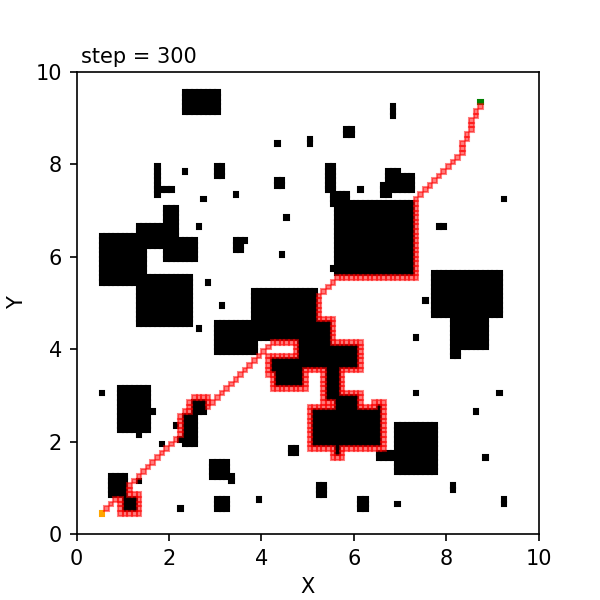

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [3]:
if __name__ == "__main__":
    time_span = 30
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([100, 100])
    
    map_data = "../csvmap/map_rl.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(BUG(world))
    
    world.draw()
    world.ani.save('bug_map_rl.gif', writer='pillow', fps=100)    #アニメーション保存